## 이미지 분류 모델 (수정 ver.)

### 모듈 불러오기 및 설치

: 아래 cell 실행 후, 없는 모듈에 대해서
> !pip install [모듈이름]

실행

sklearn의 경우, !pip install skit-learn

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import easydict
from time import sleep
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from keras.layers  import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from keras.models import load_model

In [2]:
# !pip install tensorflow

### 파일 경로 설정
#### DIR 변수에 경로 설정

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

DIR = "/content/drive/MyDrive/model_submit"
data_DIR = DIR + "/model_image"

os.listdir(data_DIR + "/image_file")

['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee',
 'Iced_Malcha_Latte_from_Jeju_Organic_Farm',
 'Vanila_Cream_Cold_Brew',
 'Iced_Grapefruit_Honey_Black_Tea',
 'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte',
 'Iced_Mint_Chocolate_Chip_Blended',
 'Java_Chip_Frappuccino',
 'Iced_Mango_Passion_Fruit_Blended',
 'Iced_Strawberry_Delight_Yogurt_Blended',
 'Iced_Caramel_Macchiato']

#### 0. 이미지 정리

In [5]:
# 메뉴별 데이터 수 확인
import os

file_path = data_DIR + "/image_file/"
file_names = os.listdir(file_path)

print("메뉴 개수: ", len(file_names), "개")
print("\n========== 메뉴별 음료 사진 개수 확인하기 ==========\n")

for coffee in file_names:
    PATH = file_path + coffee
    print(str(coffee), " : ", str(len(os.listdir(PATH))))

메뉴 개수:  10 개

========== 메뉴별 음료 사진 개수 확인하기 ==========

Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee  :  301
Iced_Malcha_Latte_from_Jeju_Organic_Farm  :  200
Vanila_Cream_Cold_Brew  :  300
Iced_Grapefruit_Honey_Black_Tea  :  300
Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte  :  302
Iced_Mint_Chocolate_Chip_Blended  :  278
Java_Chip_Frappuccino  :  300
Iced_Mango_Passion_Fruit_Blended  :  300
Iced_Strawberry_Delight_Yogurt_Blended  :  293
Iced_Caramel_Macchiato  :  299


In [6]:
# 이미지 형식 확인 ------> .png, .jpg 파일 형식만 남김
from pathlib import Path
import imghdr
from PIL import Image

image_extensions = [".png", ".jpg"]  # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# eeeeeeeee
PATH = data_DIR+'/split_image'

# 에러나는 파일이 무엇인지 확인하기 위해 빈 리스트
none_image = []
webp_image = []

for filepath in Path(PATH).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)

        if img_type is None:
            print(f"{filepath} is not an image")
            none_image.append(str(filepath))
            
            # 이미지 파일이 아닌 것은 삭제
            # https://codechacha.com/ko/python-delete-file-and-dir/
#             os.remove(str(filepath))

        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            webp_image.append(str(filepath))
            
            # 이미지 형식이 잘못된 것은 jpeg 형식으로 전환
            im = Image.open(filepath).convert("RGB")
            im.save(images, "jpeg")
            
            

# 이미지 webp 파일 경로 확인
from pprint import pprint
pprint(webp_image)

[]


#### 1. Train, Test 데이터셋 나누기

In [7]:
# 메뉴별 데이터 수
import os

file_path = data_DIR + "/split_image/"
file_names = os.listdir(file_path)

for data in file_names:
    PATH = file_path + data
    coffee_files = os.listdir(PATH)
    print("[", str(data), "data ]\n")
    
    
    for coffee in coffee_files:
        PATH_detail = os.path.join(PATH, coffee)
        print(str(coffee), " : ", str(len(os.listdir(PATH_detail))))
        
    print("\n======================================================================\n")

[ val data ]

Iced_Grapefruit_Honey_Black_Tea  :  90
Iced_Mint_Chocolate_Chip_Blended  :  83
Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee  :  90
Java_Chip_Frappuccino  :  90
Vanila_Cream_Cold_Brew  :  90
Iced_Malcha_Latte_from_Jeju_Organic_Farm  :  60
Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte  :  90
Iced_Caramel_Macchiato  :  89
Iced_Strawberry_Delight_Yogurt_Blended  :  87
Iced_Mango_Passion_Fruit_Blended  :  90


[ test data ]

Iced_Mint_Chocolate_Chip_Blended  :  84
Vanila_Cream_Cold_Brew  :  90
Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee  :  91
Iced_Malcha_Latte_from_Jeju_Organic_Farm  :  60
Iced_Grapefruit_Honey_Black_Tea  :  90
Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte  :  92
Java_Chip_Frappuccino  :  90
Iced_Caramel_Macchiato  :  91
Iced_Strawberry_Delight_Yogurt_Blended  :  89
Iced_Mango_Passion_Fruit_Blended  :  90


[ train data ]

Iced_Grapefruit_Honey_Black_Tea  :  120
Iced_Mint_Chocolate_Chip_Blended  :  111
Vanila_C

#### 2. 이미지 전처리

In [8]:
# 데이터셋 구축
from keras.preprocessing.image import ImageDataGenerator

TRAIN_PATH = data_DIR + "/split_image/train"
VAL_PATH = data_DIR + "/split_image/val"
TEST_PATH = data_DIR + "/split_image/test"

MODEL_PATH = DIR 

BATCH_SIZE = 64   # 처음 size 50
IMG_HEIGHT = 256
IMG_WIDTH = 256

trainGen = ImageDataGenerator(
    rescale = 1./255, #, 			# 값을 0과 1 사이로 변경
    rotation_range = 30,		# 무작위 회전각도 30도 이내
    # shear_range = 0.2,			# 층밀리기 강도 20% (정사각형 -> 평행사변형)
    # zoom_range = 0.2,				# 무작위 줌 범위 20%
    horizontal_flip = True 	# 무작위로 가로로 뒤짚는다.
)
valGen = ImageDataGenerator(
    rescale = 1./255#, 		
    # rotation_range = 30,	
    # shear_range = 0.2,		
    # zoom_range = 0.2,				
    # horizontal_flip = True 	
)
testGen  = ImageDataGenerator(
    rescale = 1./255#, 		
    # rotation_range = 30,	
    # shear_range = 0.2,		
    # zoom_range = 0.2,				
    # horizontal_flip = True 	
)

train_generator = trainGen.flow_from_directory(
	TRAIN_PATH,
	class_mode = "categorical",
	target_size = (IMG_HEIGHT, IMG_WIDTH),
	shuffle = True,
	batch_size = BATCH_SIZE)

# initialize the validation generator
validation_generator = valGen.flow_from_directory(
	VAL_PATH,
	class_mode = "categorical",
	target_size = (IMG_HEIGHT, IMG_WIDTH),
	shuffle = True,
	batch_size = BATCH_SIZE)

# initialize the testing generator
test_generator = testGen.flow_from_directory(
	TEST_PATH,
	class_mode = "categorical",
	target_size = (IMG_HEIGHT, IMG_WIDTH),
	shuffle = False,
	batch_size = BATCH_SIZE)

Found 1147 images belonging to 10 classes.
Found 859 images belonging to 10 classes.
Found 867 images belonging to 10 classes.


(64, 256, 256, 3)


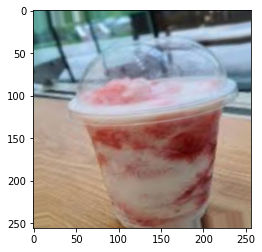

(64, 256, 256, 3)


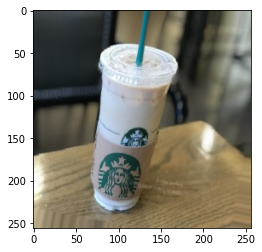

In [9]:
import matplotlib.pyplot as plt

# 이미지 확인하기 (2장가량)
for _ in range(2):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    # print(label)
    plt.imshow(img[0])
    plt.show()

labels = validation_generator.classes
# print(labels)

#### 3. 모델 생성 및 예측

In [10]:
from keras.layers import AveragePooling2D
from keras.layers  import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse

from keras.metrics import AUC

from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions

In [11]:
resnet = ResNet50V2(include_top = False,   # 맨 마지막 분류 layer 제거
                    weights = 'imagenet',   # 가중치: imagenet
                    input_shape = (256,256,3))

# 기존 학습된 layer들을 freazing
for layer in resnet.layers:
	layer.trainable = False
    
x = resnet.output
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Flatten()(x)
x = Dropout(0.8)(x)   # 기존 초기 Dropout = 0.5
x =  Dense(512, activation = 'relu', input_dim = (256,256,3))(x)
x = BatchNormalization()(x)
x =  Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
x =  Dense(10, activation = 'softmax')(x)

model = Model(inputs = resnet.input, outputs = x)

94668760/94668760 [==============================] - 0s 0us/step


In [12]:
N_EPOCH = 30
LR = 0.005   #  처음 lr = 0.05, 두번째 lr = 0.01

# compile the model
opt = Adam(learning_rate = LR, decay = LR / N_EPOCH)
model.compile(loss = "categorical_crossentropy", optimizer = opt,
	metrics = ["accuracy", AUC(multi_label = True, num_labels = 10, name = 'AUC')])

H = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = N_EPOCH,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // BATCH_SIZE)

<ipython-input-12-155c731f5b52>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/30
17/17 [==============================] - 70s 3s/step - loss: 2.1604 - accuracy: 0.3869 - AUC: 0.7844 - val_loss: 8.7910 - val_accuracy: 0.3810 - val_AUC: 0.7248
Epoch 2/30
17/17 [==============================] - 32s 2s/step - loss: 1.2651 - accuracy: 0.5873 - AUC: 0.9049 - val_loss: 3.3287 - val_accuracy: 0.5108 - val_AUC: 0.8326
Epoch 3/30
17/17 [==============================] - 32s 2s/step - loss: 0.9714 - accuracy: 0.6750 - AUC: 0.9409 - val_loss: 1.6578 - val_accuracy: 0.6334 - val_AUC: 0.9044
Epoch 4/30
17/17 [==============================] - 32s 2s/step - loss: 0.8211 - accuracy: 0.7128 - AUC: 0.9543 - val_loss: 1.7329 - val_accuracy: 0.6538 - val_AUC: 0.9034
Epoch 5/30
17/17 [==============================] - 32s 2s/step - loss: 0.7586 - accuracy: 0.7362 - AUC: 0.9607 - val_loss: 1.1930 - val_accuracy: 0.7115 - val_AUC: 0.9314
Epoch 6/30
17/17 [==============================] - 31s 2s/step - loss: 0.6473 - accuracy: 0.7802 - AUC: 0.9719 - val_loss: 1.2037 - val_acc

In [13]:
train_generator.samples

1147

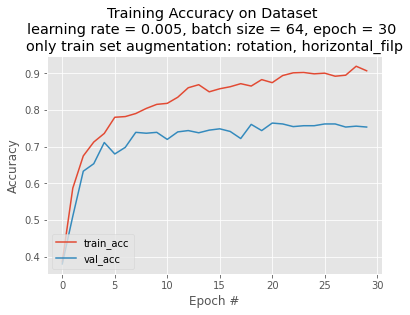

In [14]:
# Training, Validation accuracy 그리기

import easydict
args = easydict.EasyDict({
        "plot" : 'accuracy.png',
    })

N = N_EPOCH
plt.style.use("ggplot")
plt.figure()
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

# plt.plot(np.arange(0, N), H.history["AUC"], label="train_AUC")
# plt.plot(np.arange(0, N), H.history["val_AUC"], label="val_AUC")
plt.title("Training Accuracy on Dataset \nlearning rate = 0.005, batch size = 64, epoch = 30 \nonly train set augmentation: rotation, horizontal_filp")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc = "lower left")
plt.savefig(args["plot"])

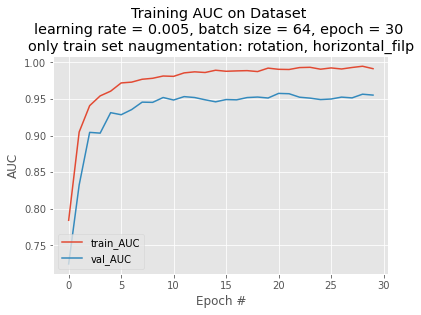

In [15]:
# Training, Validation AUC 그리기

import easydict

args = easydict.EasyDict({
        "plot" : 'auc.png',
    })

N = N_EPOCH
plt.style.use("ggplot")
plt.plot(np.arange(0, N), H.history["AUC"], label = "train_AUC")
plt.plot(np.arange(0, N), H.history["val_AUC"], label = "val_AUC")
plt.title("Training AUC on Dataset \nlearning rate = 0.005, batch size = 64, epoch = 30 \nonly train set naugmentation: rotation, horizontal_filp")
plt.xlabel("Epoch #")
plt.ylabel("AUC")
plt.legend(loc = "lower left")
plt.savefig(args["plot"])

In [16]:
# 모델 저장하기
print("[INFO] saving model...")

model.save(DIR + "/ResNet50V2_model_final_cate", save_format = "h5")

[INFO] saving model...


#### 4. 저장된 모델 불러와서 성능 확인

In [17]:
# 저장한 모델 불러오기
print("[INFO] loading model...")

from keras.models import load_model

reconstructed_model = load_model(DIR + "/ResNet50V2_model_final_cate")
reconstructed_model.summary()

[INFO] loading model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                      

##### 1) validation 성능

In [18]:
### Validation 성능 확인 ###

loss, accuracy, AUC = reconstructed_model.evaluate_generator(validation_generator,
                                                             steps = validation_generator.samples // BATCH_SIZE + 1)
print('Validation accuracy :', accuracy)
print('Validation AUC :',AUC)

<ipython-input-18-6db076b7e42e>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy, AUC = reconstructed_model.evaluate_generator(validation_generator,


Validation accuracy : 0.7555297017097473
Validation AUC : 0.9551025629043579


##### 2) test 성능

In [19]:
test_generator.classes # test data class 목록 확인

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [20]:
# test data class 이름 확인 -> target 변수에 지정
test_generator.class_indices.keys()

dict_keys(['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee', 'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte', 'Iced_Caramel_Macchiato', 'Iced_Grapefruit_Honey_Black_Tea', 'Iced_Malcha_Latte_from_Jeju_Organic_Farm', 'Iced_Mango_Passion_Fruit_Blended', 'Iced_Mint_Chocolate_Chip_Blended', 'Iced_Strawberry_Delight_Yogurt_Blended', 'Java_Chip_Frappuccino', 'Vanila_Cream_Cold_Brew'])

<ipython-input-21-a0323d883130>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = reconstructed_model.predict_generator(test_generator,


ROC AUC score: 0.8494230079475695


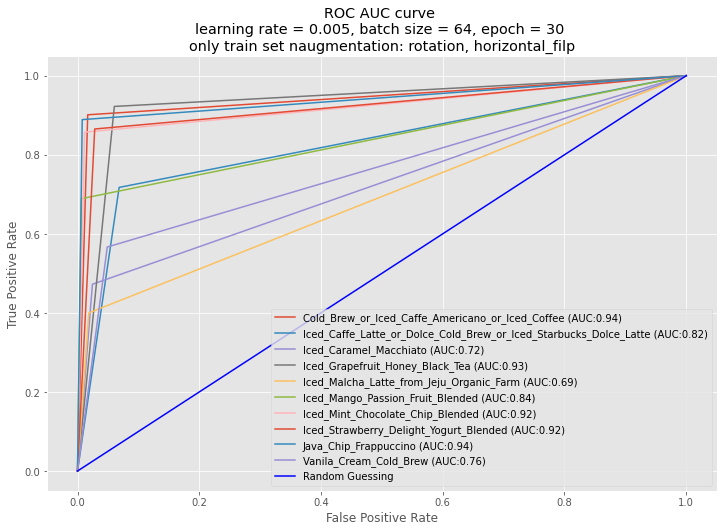

<Figure size 432x288 with 0 Axes>

In [21]:
from sklearn.metrics import multilabel_confusion_matrix

Y_pred = reconstructed_model.predict_generator(test_generator,
                                               test_generator.samples // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis = 1)

y_test = test_generator.classes

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee', 
         'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte', 
         'Iced_Caramel_Macchiato', 'Iced_Grapefruit_Honey_Black_Tea', 
         'Iced_Malcha_Latte_from_Jeju_Organic_Farm', 'Iced_Mango_Passion_Fruit_Blended', 
         'Iced_Mint_Chocolate_Chip_Blended', 'Iced_Strawberry_Delight_Yogurt_Blended', 
         'Java_Chip_Frappuccino', 'Vanila_Cream_Cold_Brew']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average = "macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average = average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred))

import easydict

args = easydict.EasyDict({
        "plot" : 'ROC AUC curve.png',
    })

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.title("ROC AUC curve \nlearning rate = 0.005, batch size = 64, epoch = 30 \nonly train set naugmentation: rotation, horizontal_filp")
plt.show()
plt.savefig(args["plot"])

In [22]:
### 메뉴별 성적 확인 ###

from sklearn.metrics import confusion_matrix, classification_report

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(test_generator.classes, y_pred,
                            target_names = test_generator.class_indices.keys()))

Confusion Matrix
[[82  3  0  2  1  0  0  0  1  2]
 [ 1 66  6  6  3  1  0  1  0  8]
 [ 1 26 43  7  2  0  1  2  1  8]
 [ 0  1  0 83  0  1  0  1  0  4]
 [ 4 12  0  4 24  1  0  3  0 12]
 [ 1  4  0 21  1 62  0  0  0  1]
 [ 0  0  0  0  1  0 72  7  4  0]
 [ 0  0  2  2  3  0  3 77  0  2]
 [ 0  0  2  1  0  0  5  1 80  1]
 [ 6  7  9  4  4  2  0  7  0 51]]
Classification Report
                                                                   precision    recall  f1-score   support

                 Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee       0.86      0.90      0.88        91
Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte       0.55      0.72      0.63        92
                                           Iced_Caramel_Macchiato       0.69      0.47      0.56        91
                                  Iced_Grapefruit_Honey_Black_Tea       0.64      0.92      0.75        90
                         Iced_Malcha_Latte_from_Jeju_Organic_Farm       0.62      0.40      0.

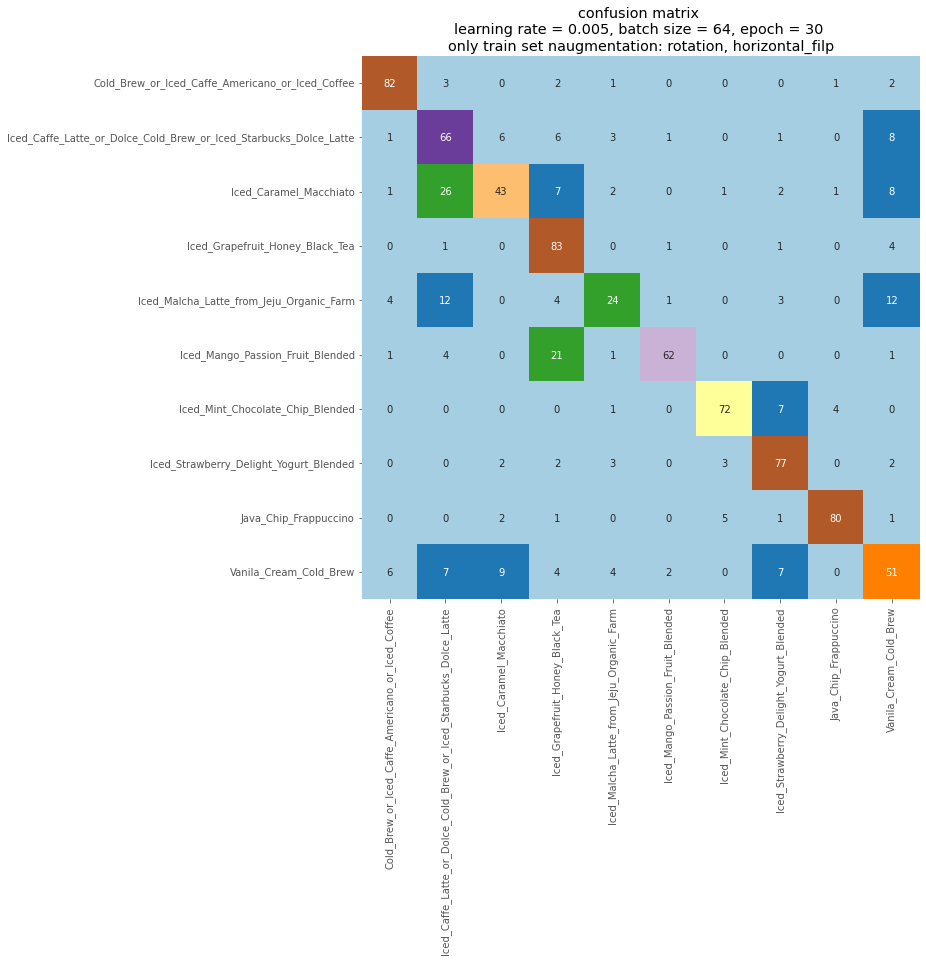

<Figure size 432x288 with 0 Axes>

In [23]:
### confusion matrx 그리기 ### 

import seaborn as sns

y_test = test_generator.classes
cmat = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10,10))

# label =[0,1,2,3,4,5,6,7,8,9]


label = ['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee', 
         'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte', 
         'Iced_Caramel_Macchiato', 'Iced_Grapefruit_Honey_Black_Tea', 
         'Iced_Malcha_Latte_from_Jeju_Organic_Farm', 'Iced_Mango_Passion_Fruit_Blended', 
         'Iced_Mint_Chocolate_Chip_Blended', 'Iced_Strawberry_Delight_Yogurt_Blended', 
         'Java_Chip_Frappuccino', 'Vanila_Cream_Cold_Brew']

import easydict

args = easydict.EasyDict({
        "plot" : 'confusion matrix.png',
    })

sns.heatmap(cmat, annot = True, cbar = False, cmap = 'Paired',
            fmt = "d", xticklabels = label, yticklabels = label);
plt.title("confusion matrix \nlearning rate = 0.005, batch size = 64, epoch = 30 \nonly train set naugmentation: rotation, horizontal_filp")
plt.show()
plt.savefig(args["plot"])

#### 5. predict 데이터로 예측이 잘 되는지 시각화

In [24]:
import os

predict_path = data_DIR +"/predict_image"
predict_images = os.listdir(predict_path)
predict_images

['Cold_Brew_or_Iced_Caffe_Americano_or_Iced_Coffee_predict.jpg',
 'Iced_Malcha_Latte_from_Jeju_Organic_Farm_predict.jpg',
 'Iced_Mint_Chocolate_Chip_Blended_predict.jpeg',
 'Iced_Mango_Passion_Fruit_Blended_predict.jpg',
 'Vanila_Cream_Cold_Brew_predict.jpg',
 'Iced_Strawberry_Delight_Yogurt_Blended_predict.jpg',
 'Iced_Caramel_Macchiato_predict.jpg',
 'Iced_Caffe_Latte_or_Dolce_Cold_Brew_or_Iced_Starbucks_Dolce_Latte_predict.jpg',
 'Java_Chip_Frappuccino_predict.jpg',
 'Iced_Grapefruit_Honey_Black_Tea_predict.jpg']

1/1 [==============================] - 0s 24ms/step
음료 사진의 실제 카테고리 :  Iced_Grapefruit_Honey_Black_Tea
음료 사진의 분류된 카테고리 :  Iced_Grapefruit_Honey_Black_Tea


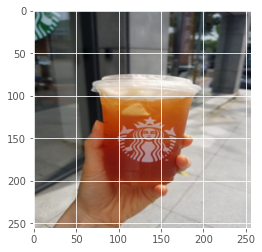

In [25]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

# predict_images에서 랜덤으로 하나의 이미지를 가져옴
# random.seed(128)   # 실제로는 계속 바꿔줄 수 있음
# random_number = random.randrange(0, 10)

for i in range(10):
    
    # 적용해볼 이미지
    predict_image_path = predict_path + "/" + predict_images[i]

    # 이미지 resize
    img = Image.open(predict_image_path)
    img = img.convert("RGB")
    img = img.resize((256, 256))
    data = np.asarray(img)

    X = np.array(data)
    X = X.astype("float") / 255
    X = X.reshape(1, 256, 256,3)


    # 예측
    pred = reconstructed_model.predict(X)  
    result = [np.argmax(value) for value in pred]   # 예측 값중 가장 높은 클래스 반환
    print("음료 사진의 실제 카테고리 : ", predict_images[i].replace("_predict.jpg", ""))
    print('음료 사진의 분류된 카테고리 : ', label[result[0]])


    # 이미지 확인하기
    plt.imshow(img)
    plt.show()
    sleep(2)
    clear_output(wait=True)